# Running and Plotting LightCones

This tutorial follows on from the [coeval cube tutorial](coeval_cubes), and provides an introduction to creating lightcones with ``21cmFAST``. If you are new to ``21cmFAST`` you should go through the coeval cube tutorial first.

The main entry point into creating lightcones in 21cmFAST is the ``run_lightcone`` function. The function takes a few different arguments, most of which will be familiar to you if you've gone through the coeval tutorial.

The main concept to grasp here is that a lightcone is made simply by running a number
of Coeval simulations at different redshifts, and interpolating them together.
The redshifts that are computed are simply set by the `InputParameters.node_redshifts`
parameter.

There are in principle multiple ways to set up a lightcone: there is a choice of whether the box itself should be regular in transverse comoving distance (like the coeval boxes) or exist on an angular lattice. In 21cmFAST < 3.3.0, all lightcones were output in regular, comoving, rectilinear coordinates such that each "cell" was cubic and had the size of the coeval cubes used to make it. In 21cmFAST v3.3+, there is much more flexibility. You use a `Lightconer` subclass to tell the code what your lightcone should look like, and you can specify your own sub-class if the builtin ones don't do what you require. The default lightconer is the same regular rectilinear grid as was used in 21cmFAST<3.3.

In [ ]:
import os
from tempfile import mkdtemp

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as un
from matplotlib import cm, colors
from scipy.spatial.transform import Rotation

import py21cmfast as p21c
from py21cmfast import plotting

%matplotlib inline

In [2]:
cache = p21c.OutputCache(mkdtemp())

Let's set up a standard rectilinear lightcone subclass.

The final *minimum* redshift of the lightcone is set by the ``min_redshift`` argument, and the maximum redshift of the lightcone is defined by the ``max_redshift`` argument (note that this is not the maximum redshift coeval box computed, which is instead controlled by ``z_heat_max``, merely the maximum saved into the returned lightcone). 

You can specify which 3D quantities are interpolated as lightcones as well (these must be fields that exist on any standard output box).

In [ ]:
inputs = p21c.InputParameters.from_template(
        'simple',
        node_redshifts=p21c.wrapper.inputs.get_logspaced_redshifts(
            min_redshift=7.0,
            z_step_factor=1.1,
            max_redshift=12.0,
        ),
        random_seed=1234,
    ).evolve_input_structs(HII_DIM=64, BOX_LEN=128, INCLUDE_DVDR_IN_TAU21=False)

In [4]:
lcn = p21c.RectilinearLightconer.between_redshifts(
    min_redshift=7.0,
    max_redshift=12.0,
    quantities=("brightness_temp", "density"),
    resolution=inputs.simulation_options.cell_size,
    # index_offset=0,
)

Notice the `index_offset` argument above. When creating the lightcone, the slice of the coeval box that makes the first slice of the lightcone is arbitrary. By setting `index_offset` to zero, we set the very back of the lightcone to be equal to the last slice of the coeval. The default is to have the *first* slice of the lightcone correspond to the *first* slice of the coeval.

When running the lightcone itself, like the `run_coeval` function, the `run_lightcone`
function is a generator -- at every node redshift, it yields the updated lightcone, filled
to the currently computed redshift. This allows you to do whatever you like with the lightcone
at each iteration. However, if you just want the final lightcone, you can call the
convenience method `.exhaust_lightcone()` instead of `run_lightcone`.

In [5]:
idx, z, coeval, lightcone = p21c.run_lightcone(
    lightconer=lcn,
    global_quantities=("brightness_temp", "density", "neutral_fraction"),
    inputs=inputs,
    cache=cache,
    progressbar=True
)

Evolving Astrophysics: 100%|██████████| 7/7 [00:08<00:00,  1.23s/redshift]


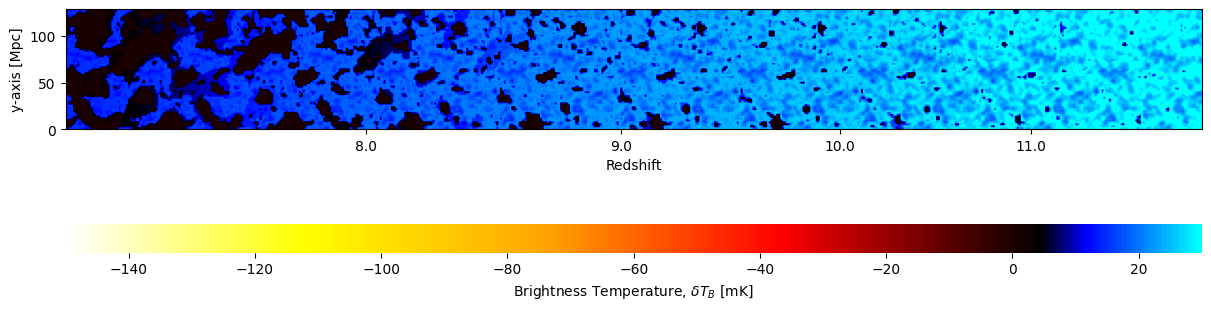

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
plotting.lightcone_sliceplot(lightcone, ax=ax, fig=fig);

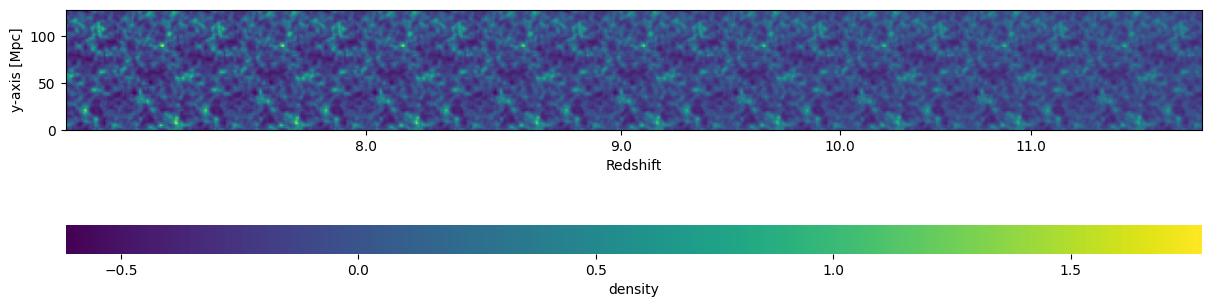

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
plotting.lightcone_sliceplot(lightcone, "density", ax=ax, fig=fig);

Simple!

## Using an Angular Lightcone

Say we would like to save our lightcone in angular coordinates. We can do this with the `AngularLightconer` subclass. This class requires you to pass a set of latitude (from $-\pi/2$ to $\pi/2$) and longitude (0 to $2\pi$) points. It does not require these to be on a grid of any form (though often that is what you'll want). A common use-case would be to use a regular grid in (lat, lon) that roughly covers the coeval box size (at the low-z end). Another common use-case would be to use some subset of a HEALPix map (or maybe the full map, if you'd like to go on and use these simulations to produce visibilities!).

This lightconer is able to deal with full sky or any subset.

In this case, for ease of visualization, we will set up a regular (lon, lat) grid that is similar in size and resolution to our coeval box. Since we'd like to see the "transverse face" of the lightcone and see that it looks like the face of the rectilinear lightcone, we need to set a few options. First, set the angular region:

In [8]:
cosmo = lightcone.cosmo_params.cosmo

In [9]:
box_size_radians = inputs.simulation_options.BOX_LEN / cosmo.comoving_distance(7.0).value

In [10]:
lon = np.linspace(0, box_size_radians, inputs.simulation_options.HII_DIM)
lat = np.linspace(0, box_size_radians, inputs.simulation_options.HII_DIM)[
    ::-1
]  # This makes the X-values increasing from 0.

In [11]:
LON, LAT = np.meshgrid(lon, lat)
LON = LON.flatten()
LAT = LAT.flatten()

So far, we have just specified a small grid that should roughly line up with the coeval box, but it is close to the $x$-axis. Natively, the rectilinear lightcone uses the last axis (the $z$ axis) as the line-of-sight. We can use the options `origin` and `rotation` to align our specified co-ordinates with the rectilinear lightcone. 

The first operation applied is the `rotation`. In our case, we want to rotate our angles from being close to the $x$-axis, to instead being close to the $z$-axis (imagine a small squarish region of pixels perpendicular to and close to the $z$-axis). This means we need to rotate the co-ordinates by 90 degrees around the $y$-axis. Secondly, we apply an offset. The rectilinear lightcone is constructed in such a way that the first slice at the lowest redshift corresponds to the first slice along the $z$-axis. We achieve this by displacing the origin by the comoving distance to the minimum redshift. Note also that we constructed our initial latitude grid to go from high elevation down to the horizon. When the grid is rotated up to be close to the $z$-axis, this gets the $x$-coordinates going from left-to-right instead of the other way around.

In [12]:
offset = cosmo.comoving_distance(lightcone.lightcone_redshifts.min()).to(
    un.pixel, un.pixel_scale(inputs.simulation_options.cell_size / un.pixel)
)
origin = np.array([0, 0, offset.value]) * offset.unit
rot = Rotation.from_euler("Y", -np.pi / 2)

Now we can construct the lightconer, using the `AngularLightconer` class

In [13]:
ang_lcn = p21c.AngularLightconer.between_redshifts(
    min_redshift=7.0,
    max_redshift=12.0,
    quantities=("brightness_temp", "density"),
    resolution=inputs.simulation_options.cell_size,
    latitude=LAT,
    longitude=LON,
    origin=-origin,
    rotation=rot,
)

Since it is a common thing to want to get an angular lightcone that "looks like" the coeval
box at some redshift, we provide a convenience method for creating it:

In [14]:
ang_lcn2 = p21c.AngularLightconer.like_rectilinear(
    match_at_z=7.0,
    max_redshift=12.0,
    simulation_options=inputs.simulation_options,
    quantities=("brightness_temp", "density"),
)

This convenience method gives the same lightcone we manually got above:

In [15]:
ang_lcn == ang_lcn2

True

In [16]:
idx, z, coeval, ang_lightcone = p21c.run_lightcone(
    lightconer=ang_lcn,
    global_quantities=("brightness_temp", "density", "neutral_fraction"),
    inputs=inputs,
    cache=cache,
)

In this case, the output lightcone has a different type than the default rectilinear `Lightcone`:

In [17]:
type(ang_lightcone)

py21cmfast.drivers.lightcone.AngularLightcone

The boxes in `ang_lightcone` have their transverse coordinates packed up into one dimension (because, again, there is no assumption that the angular coordinates were in a regular grid). In our specific case here, they *are* in a grid, so let's reshape the array to make it look like our rectilinear lightcone:

In [18]:
bt = ang_lightcone.lightcones["brightness_temp"].reshape(
    (inputs.simulation_options.HII_DIM, inputs.simulation_options.HII_DIM, len(ang_lightcone.lightcone_distances))
)

Now we can plot the rectilinear and angular lightcones beside each other to check that they are similar. Here we simply plot the face of the lightcone at the lowest redshift:

Text(0, 0.5, 'Transverse (y) dimension [cMpc]')

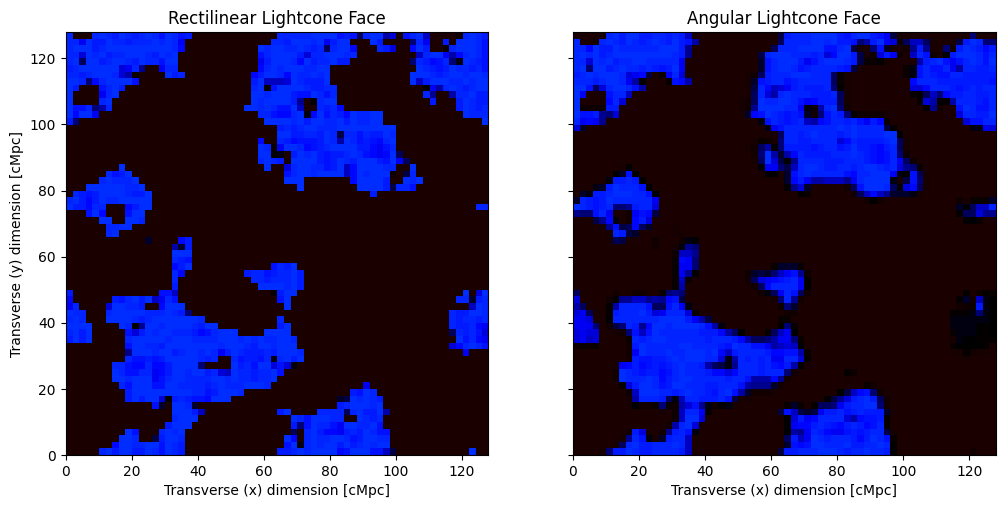

In [22]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
kw = {
    "origin": "lower",
    "extent": (0, inputs.simulation_options.BOX_LEN, 0, inputs.simulation_options.BOX_LEN),
    "cmap": "EoR",
    "vmin": -150,
    "vmax": 30,
}

ax[0].imshow(lightcone.lightcones["brightness_temp"][:, :, 0], **kw)
ax[0].set_title("Rectilinear Lightcone Face")
ax[1].imshow(bt[:, :, 0], **kw)
ax[1].set_title("Angular Lightcone Face")

ax[0].set_xlabel("Transverse (x) dimension [cMpc]")
ax[1].set_xlabel("Transverse (x) dimension [cMpc]")
ax[0].set_ylabel("Transverse (y) dimension [cMpc]")

Here, we see that the upper left corner of the plots is very similar -- this is where the two grids overlap almost exactly. Moving to the bottom right corner, the angular lightcone "curves away" from the rectilinear, and so the plots become less similar. Plotting the same thing but at the highest redshift:

Text(0, 0.5, 'Transverse (y) dimension [cMpc]')

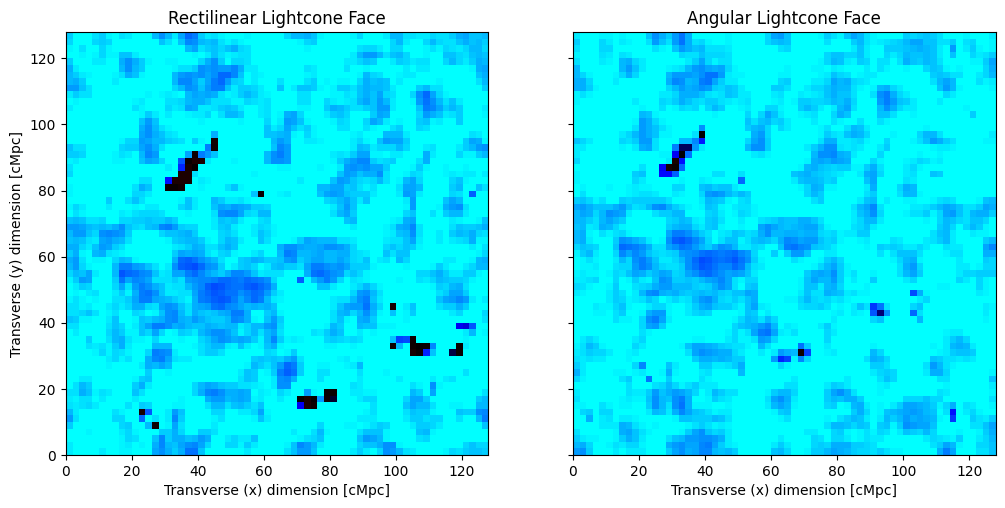

In [23]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
ax[0].imshow(lightcone.lightcones["brightness_temp"][:, :, -1], **kw)
ax[0].set_title("Rectilinear Lightcone Face")
ax[1].imshow(bt[:, :, -1], **kw)
ax[1].set_title("Angular Lightcone Face")

ax[0].set_xlabel("Transverse (x) dimension [cMpc]")
ax[1].set_xlabel("Transverse (x) dimension [cMpc]")
ax[0].set_ylabel("Transverse (y) dimension [cMpc]")

We see that the upper left is still very similar, but changes much more radidly moving away from that point, as we would expect, since we have tried to ensure that the angular coordinates align at the lowest redshift, and the angular lightcone "fans out" towards higher redshift.

## Plotting evolution of the angular lightcone

We can also plot the evolution of the lightcone, choosing one transverse slice:

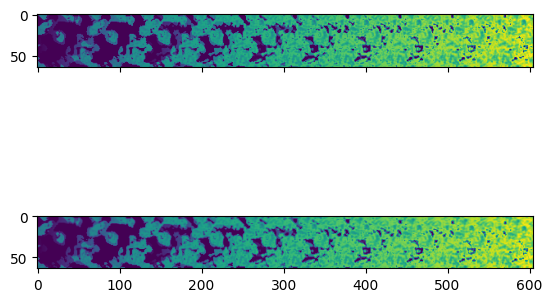

In [24]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].imshow(lightcone.lightcones["brightness_temp"][:, 0])
ax[1].imshow(bt[:, 0])

Here we see a very similar evolution, since we have chosen a slice that corresponds best to the rectilinear lightcone.

We can get a more accurate representation of the angular lightcone by plotting it in polar coordinates. Here, we can just plot a slice corresponding to the horizon:

/Users/jordanflitter/opt/anaconda3/envs/V4_ENV/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)


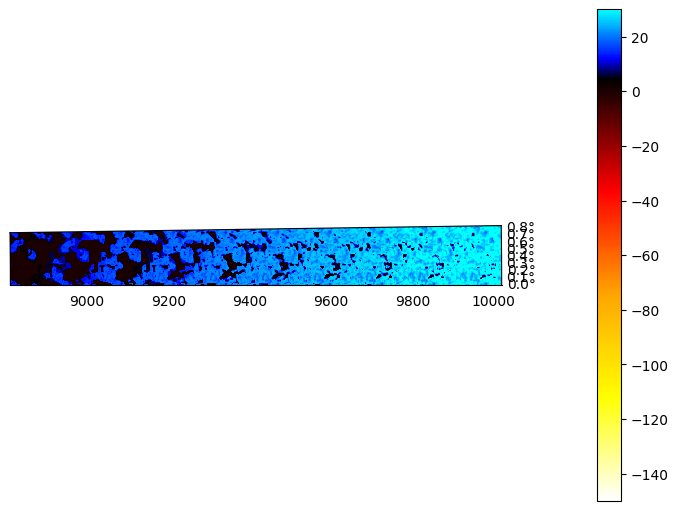

In [25]:
fig, ax = plt.subplots(
    1, 1, figsize=[14, 5], constrained_layout=True, subplot_kw={"projection": "polar"}
)

ax.set_thetamax(lat.max() * 180 / np.pi)
ax.set_ylim(ang_lcn.lc_distances.min().value, ang_lcn.lc_distances.max().value)
ax.set_rorigin(0)
H, D = np.meshgrid(lat, ang_lcn.lc_distances.value)
plt.grid(False)
img = ax.pcolormesh(H, D, bt[:, 0].T, edgecolors="face", cmap="EoR", vmin=-150, vmax=30)
plt.colorbar(img)

Here, the radial axis corresponds to comoving distance, and we have used the built-in "EoR" colormap provided by 21cmFAST.

## Saving the Lightcones

You can easily save a HDF5 file containing the interpolated lightcone:

In [26]:
filename = lightcone.save(cache.direc / "lightcone.h5", clobber=True)

And for the angular lightcone:

In [27]:
ang_lightcone.save(cache.direc / "big_angular_lightcone.h5")

## Overcoming blurry edges

Since the angular lightcone has to be interpolated (in the angular direction) from a rectilinear coeval box, it will tend to "blur" edges of ionized regions that would otherwise be sharp. This will reduce the power on small scales compared to the truth. To overcome this, you can try setting the resolution higher, or the interpolation order, or both:

In [28]:
lon = np.linspace(0, box_size_radians, inputs.simulation_options.HII_DIM)
lat = np.linspace(0, box_size_radians, inputs.simulation_options.HII_DIM)[
    ::-1
]  # This makes the X-values increasing from 0.

In [29]:
lonhires = np.linspace(0, box_size_radians, inputs.simulation_options.HII_DIM * 4)
lathires = np.linspace(0, box_size_radians, inputs.simulation_options.HII_DIM * 4)[
    ::-1
]  # This makes the X-values increasing from 0.

In [30]:
LON, LAT = np.meshgrid(lon, lat)
LON = LON.flatten()
LAT = LAT.flatten()

In [31]:
LONhires, LAThires = np.meshgrid(lonhires, lathires)
LONhires = LONhires.flatten()
LAThires = LAThires.flatten()

In [32]:
ang_lcn_cubic = p21c.AngularLightconer.between_redshifts(
    min_redshift=7.0,
    max_redshift=7.2,
    quantities=("brightness_temp", "density"),
    resolution=inputs.simulation_options.cell_size,
    latitude=LAT,
    longitude=LON,
    origin=-origin,
    rotation=rot,
    interpolation_order=3,
)

In [33]:
ang_lcn_hires = p21c.AngularLightconer.between_redshifts(
    min_redshift=7.0,
    max_redshift=7.2,
    quantities=("brightness_temp", "density"),
    resolution=inputs.simulation_options.cell_size,
    latitude=LAThires,
    longitude=LONhires,
    origin=-origin,
    rotation=rot,
)

In [34]:
_,_,_,ang_lightcone_hires = p21c.run_lightcone(
    lightconer=ang_lcn_hires,
    global_quantities=("brightness_temp", "density", "neutral_fraction"),
    cache=cache,
    inputs=inputs,
)

In [35]:
_,_,_,ang_lightcone_cubic = p21c.run_lightcone(
    lightconer=ang_lcn_cubic,
    global_quantities=("brightness_temp", "density", "neutral_fraction"),
    cache=cache,
    inputs=inputs,
)

Text(0, 0.5, 'Transverse (y) dimension [cMpc]')

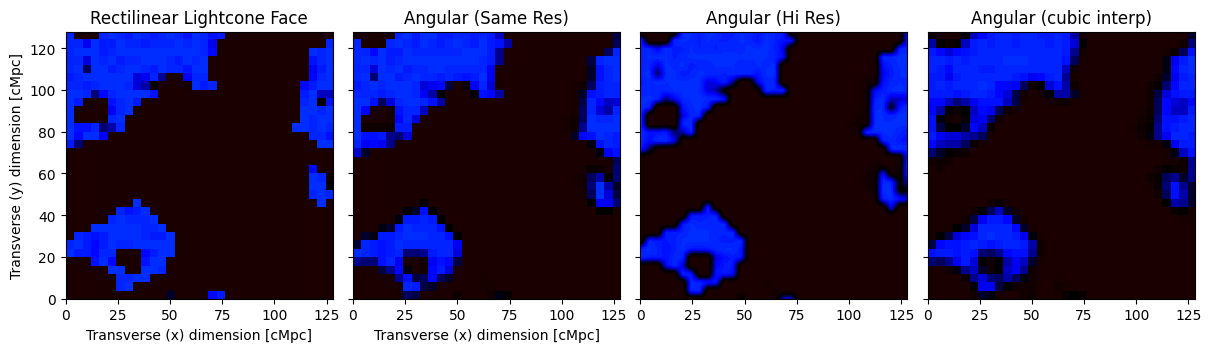

In [36]:
fig, ax = plt.subplots(
    1, 4, sharex=True, sharey=True, figsize=(12, 20), constrained_layout=True
)

bt = ang_lightcone.lightcones['brightness_temp'][:, 0].reshape(
    inputs.simulation_options.HII_DIM, inputs.simulation_options.HII_DIM
)
bthires = ang_lightcone_hires.lightcones['brightness_temp'][:, 0].reshape(
    inputs.simulation_options.HII_DIM * 4, inputs.simulation_options.HII_DIM * 4
)

n = inputs.simulation_options.HII_DIM

ax[0].imshow(
    lightcone.lightcones['brightness_temp'][n // 2 :, : n // 2, 0],
    origin="lower",
    extent=(0, inputs.simulation_options.BOX_LEN, 0, inputs.simulation_options.BOX_LEN),
    cmap="EoR",
    vmin=-150,
    vmax=30,
)
ax[0].set_title("Rectilinear Lightcone Face")
ax[1].imshow(
    bt[n // 2 :, : n // 2],
    origin="lower",
    extent=(0, inputs.simulation_options.BOX_LEN, 0, inputs.simulation_options.BOX_LEN),
    cmap="EoR",
    vmin=-150,
    vmax=30,
)
ax[1].set_title("Angular (Same Res)")

ax[2].imshow(
    bthires[n * 2 :, : n * 2],
    origin="lower",
    extent=(0, inputs.simulation_options.BOX_LEN, 0, inputs.simulation_options.BOX_LEN),
    cmap="EoR",
    vmin=-150,
    vmax=30,
)
ax[2].set_title("Angular (Hi Res)")


btcubic = ang_lightcone_cubic.lightcones['brightness_temp'][:, 0].reshape(
    inputs.simulation_options.HII_DIM, inputs.simulation_options.HII_DIM
)

ax[3].imshow(
    btcubic[n // 2 :, : n // 2],
    origin="lower",
    extent=(0, inputs.simulation_options.BOX_LEN, 0, inputs.simulation_options.BOX_LEN),
    cmap="EoR",
    vmin=-150,
    vmax=30,
)
ax[3].set_title("Angular (cubic interp)")


ax[0].set_xlabel("Transverse (x) dimension [cMpc]")
ax[1].set_xlabel("Transverse (x) dimension [cMpc]")
ax[0].set_ylabel("Transverse (y) dimension [cMpc]")

## Higher Resolution Run For Visualization

In [37]:
if os.environ.get("TEST_RUN", "False") == "True":
    raise SystemExit

So far, we have constructed our angular lightcone to be similar in size and resolution to the rectilinear lightcone. But as we've said, there is no restriction on the angular coordinates that can be put in. You could input the coordinates from a full-sky healpix map. To illustrate using a wider set of coordinates, let's create a "lightplane" taking a set of regular coordinates on the horizon, extending back into the line of sight. We do this for a wide angle (~22.5 degrees, or about 6 of our boxes stacked). In this case, we use no rotation or origin offset:

In [38]:
lath = np.zeros(3000)
lonh = np.linspace(0, np.pi / 8, 3000)

For this last run, let's setup a much more realistically-sized simulation, to get a nicer visualization:

In [ ]:
inputs_hires = p21c.InputParameters.from_template(
        'simple',
        node_redshifts=p21c.wrapper.inputs.get_logspaced_redshifts(
            min_redshift=7.0,
            z_step_factor=1.1,
            max_redshift=40.0,
        ),
        random_seed=1234,
    ).evolve_input_structs(
        BOX_LEN=900.0,
        HII_DIM=600,
        DIM=1200,
        USE_TS_FLUCT=True,
        INCLUDE_DVDR_IN_TAU21=False)

In [48]:
ang_lcn_horiz = p21c.AngularLightconer.between_redshifts(
    min_redshift=7.0,
    max_redshift=30.0,
    quantities=("brightness_temp", "density"),
    resolution=inputs.simulation_options.cell_size,
    latitude=lath,
    longitude=lonh,
)

In [ ]:
_,_,_,lc_horiz = ang_lightcone = p21c.run_lightcone(
    lightconer=ang_lcn_horiz,
    global_quantities=("brightness_temp", "density", "neutral_fraction"),
    cache=cache,
    inputs=inputs_hires,
    regenerate=False,
    progressbar=True,
)

When plotting, we add some grid lines identifying roughly the positions of the stacked underlying boxes (the one closest to the actual stacked coeval position is the one closest to $\theta=0$). 

In [ ]:
from astropy import units
from astropy.cosmology import z_at_value

In [ ]:
def get_eor_cmap(vmin=-150, vmax=30):
    name = f"EoR-{vmin}-{vmax}"
    negative_segments = 4
    positive_segments = 2
    neg_frac = abs(vmin) / (vmax - vmin)
    neg_seg_size = neg_frac / negative_segments
    pos_frac = abs(vmax) / (vmax - vmin)
    pos_seg_size = pos_frac / positive_segments
    eor_colour = colors.LinearSegmentedColormap.from_list(
        name,
        [
            (0, "white"),
            (neg_seg_size, "yellow"),
            (neg_seg_size * 2, "orange"),
            (neg_seg_size * 3, "maroon"),
            (neg_seg_size * 4, "black"),
            (neg_seg_size * 4 + pos_seg_size, "#1f77b4"),
            (1, "skyblue"),
        ],
    )
    try:
        plt.register_cmap(cmap=eor_colour)
    except ValueError:
        cm.unregister_cmap(name)
        plt.register_cmap(cmap=eor_colour)

    return name

/tmp/ipykernel_56332/325665923.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  img = ax.pcolormesh(H, D, lc_horiz.brightness_temp.T, edgecolors='face', cmap=cmap, vmin=vmin, vmax=vmax)


Text(0.5, -0.06, 'Redshift')

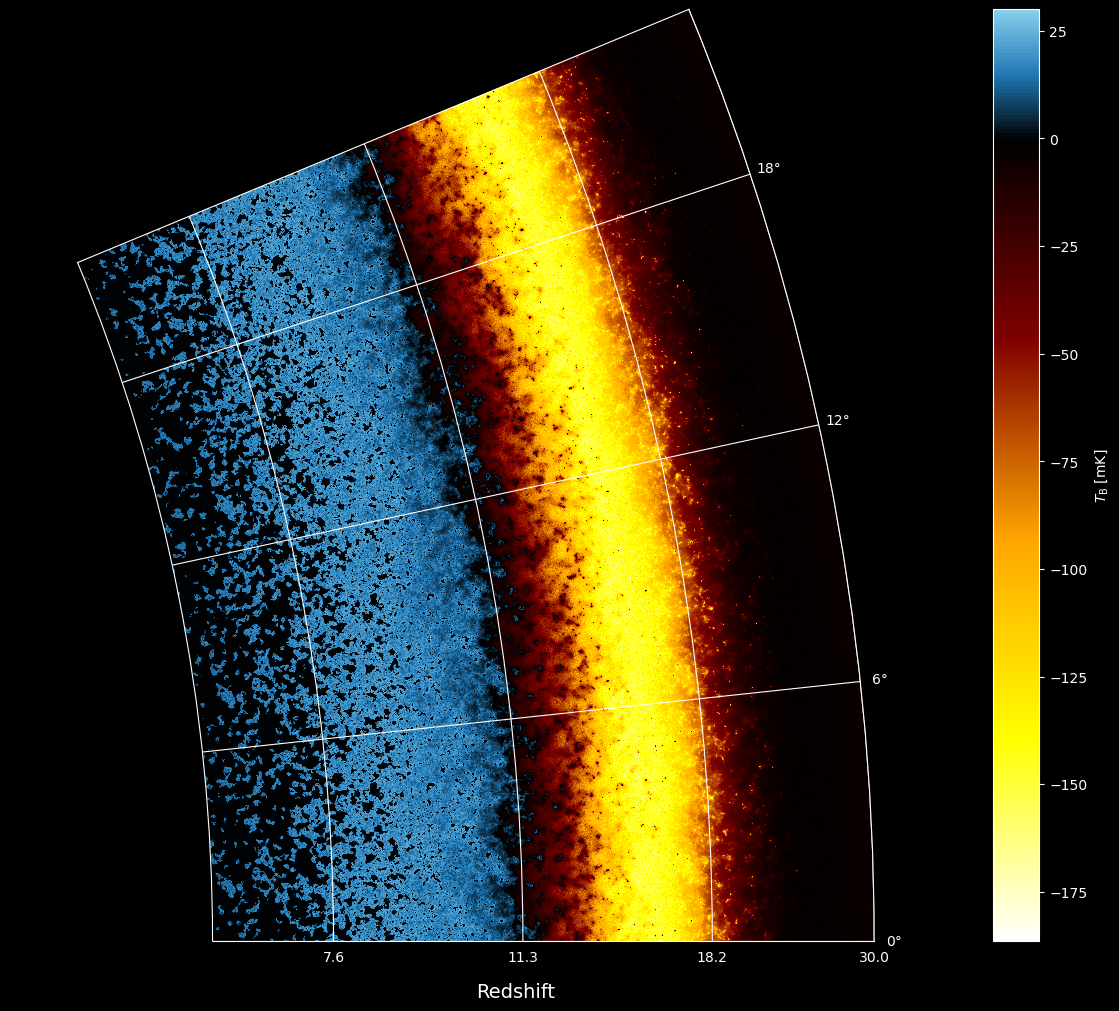

In [ ]:
plt.style.use("dark_background")

fig, ax = plt.subplots(
    1, 1, figsize=[12, 10], constrained_layout=True, subplot_kw={"projection": "polar"}
)

vmin, vmax = lc_horiz.brightness_temp.min(), 30.0
cmap = get_eor_cmap(vmin, vmax)

theta = (
    inputs_hires.simulation_options.BOX_LEN
    / ang_lcn_horiz.cosmo.comoving_distance(ang_lcn_horiz.lc_redshifts.min()).value
)
nchunks = int(lonh.max() / theta) + 1
ax.set_thetamax(lonh.max() * 180 / np.pi)
ax.set_ylim(
    ang_lcn_horiz.lc_distances.min().value, ang_lcn_horiz.lc_distances.max().value
)
ax.set_rorigin(0)
H, D = np.meshgrid(lonh, ang_lcn_horiz.lc_distances.value)
img = ax.pcolormesh(
    H, D, lc_horiz.brightness_temp.T, edgecolors="face", cmap=cmap, vmin=vmin, vmax=vmax
)
cax = plt.colorbar(img)
cax.set_label(r"$T_{\rm B}$ [mK]")
ax.set_thetagrids(np.arange(nchunks) * theta * 180 / np.pi)
rgrid = np.arange(0, D.max(), inputs_hires.simulation_options.BOX_LEN)
rgrid = rgrid[rgrid > D.min()]
rgrid = np.append(rgrid, D.max())
ax.set_rgrids(
    rgrid,
    labels=[
        f"{z_at_value(ang_lcn_horiz.cosmo.comoving_distance, d * units.Mpc).value:.1f}"
        for d in rgrid
    ],
)
ax.grid(True)
# ax.set_xlabel("Redshift")
ax.text(0.5, -0.06, "Redshift", fontsize=14, transform=ax.transAxes)